# 영화 대시보드 (현황판) 만들기

- 각 그룹 별로 주어진 데이터를 받아 자유롭게 대시보드를 만들어주세요. (DB: Kaggle movie)
- 분석된 그래프를 이미지로 저장하여 PPT 혹은 그림판에 붙여서 한 장으로 만들어 제출
- 평가 기준: 데이터 분석 능력, 적절한 그래프 선택, 의미/의도 전달
- 가로는 화면 가로 크기로 지정하지만 세로 길이는 자유입니다.
- 기한은 **월요일 점심**까지
- 주의사항:
    - 이번 미니프로젝트는 발표가 없습니다. 처음 보는 사람이 의도와 의미를 알 수 있게 만들어주세요.
    - 여러가지 그래프의 형태를 시도해보세요.
    - 만약 정말 그리고 싶은데 코딩할 수 없다면 1~2개는 손으로 그려서 올리세요.
    - 다양한 시도를 해보는 도전 정신을 높게 평가합니다.

팀원: 심우종, 최민식, 강도하, 박민지

# 데이터 전처리

In [ ]:
pd.set_option('mode.chained_assignment',  None)

import pandas as pd
import ast
import numpy as np
movies = pd.read_csv('/content/drive/MyDrive/dataset/01_kaggle_movie/movies_metadata.csv', low_memory = False)
df = movies[['original_title', 'genres', 'release_date', 'budget', 'revenue', 'popularity', 'vote_average']]

def toFloat(pop):
    ret = 0.
    try:
        ret = float(pop)
    except:
        ret = 0.0
    return ret

def getyear(rdate):
    try:
        tmp = rdate.split('-')
        if len(tmp) != 3:
            return "None"
        else:
            return tmp[0]
    except:
        return "None"

def getMonth(rdate):
    try:
        tmp = rdate.split('-')
        if len(tmp) != 3:
            return "None"
        else:
            return tmp[1]
    except:
        return "None"


df['budget'] = df['budget'].apply(toFloat)
df['revenue'] = df['revenue'].apply(toFloat)
df['popularity'] = df['popularity'].apply(toFloat)
df['month'] = df['release_date'].apply(getMonth)
df['year'] = df['release_date'].apply(getyear)
df['vote_average'] = df['vote_average'].apply(toFloat)

tmpDF = df[(df['budget'] != 0) & (df['revenue'] != 0) & (df['popularity'] != 0) & (df['genres'] != '[]') & (df['year'] != 'None') & (df['vote_average'] != 0)]
cols = ['genres', 'year', 'month', 'budget', 'revenue', 'popularity', 'vote_average']
tmpDF = tmpDF[cols]
newdf = pd.DataFrame(columns = cols)

# 영화 하나에 장르가 여러개라서 모든 장르를 살리기 위해 장르를 parsing하여 새로운 테이블 생성
for idx, rows in tmpDF.iterrows():
    tmp = ast.literal_eval(rows['genres'])#genre, year, month, bud, rev, pop, vote
    lis = list()
    for i in tmp:
        li = [i['name'], rows['year'], rows['month'], rows['budget'], rows['revenue'], rows['popularity'], rows['vote_average']]
        lis.append(li)
    tmpDF = pd.DataFrame(lis, columns = cols)

    newdf = pd.concat([newdf, tmpDF], ignore_index=True)

newdf['percent'] = np.log10((newdf['revenue'] / newdf['budget'])*100) * 30 - 50
print(newdf)

# table merge
vote = newdf.groupby('genres').mean()[['vote_average']]
percent = newdf.groupby('genres').mean()[['percent']]
count = newdf.groupby('genres').count()[['budget']]
count = count.rename(columns = {'budget':'count'})
count10 = newdf[newdf['year'] >= '2013'].groupby('genres').count()['revenue']

# final
# count : 장르별 전체 카운트
# count_10 : 최근 10년 장르별 개봉 영화 수
# avg_percent : 장르별 상대적 수익 / 투자 비
# avg_popularity : 장르별 평균 평점
final = vote.join(percent).join(count).join(count10)
final = final.rename(columns = {'budget':'count', 'revenue':'count10'})
final['count10'] = final['count10'].fillna(0)

# drama
# 월별 드라마 개봉 영화 수
drama = newdf[newdf['genres'] == 'Drama'].groupby('month').count()[['year']]

# inal = pd.read_csv('/content/drive/MyDrive/dataset/final.csv')
# final.to_csv('/content/drive/MyDrive/dataset/final.csv')

# 장르별 키워드

장르별로 키워드 및 키워드 빈도를 데이터화하기

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/MyDrive')

# 구글 드라이브에 있는 캐글 영화 데이터셋 압축 해제
!unzip -qq '/content/MyDrive/MyDrive/Colab Notebooks/Dataset/kaggle_movie.zip'

# 필요한 라이브러리 추출
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:
# 필요한 데이터들만 살펴보기
file_list = ['keywords', 'movies_metadata']

df_dict = {}
for file in file_list:
    path = '/content/'
    df_dict[file] = pd.read_csv(path + file + '.csv')
kws = df_dict['keywords']
mmd = df_dict['movies_metadata']

In [ ]:
mmd.head()

In [ ]:
mmd.info()

In [ ]:
kws.info()

In [ ]:
kws.head()

Keywords는 영화의 id별로 (metadata에 있는 id열) 각 영화의 키워드를 정리한 데이터로 보인다.
따라서 metadata를 전처리한 후 id에 따라 merge하면 영화별 키워드 데이터를 생성할 수 있을 것이다.

In [ ]:
df = mmd.loc[:, ['genres', 'id', 'original_title']]
df.head()

,genres,id,original_title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II


genres 열에 있는 데이터 값들은 딕셔너리들의 리스트인 것으로 보이나  
실제로 값 하나를 추출해 type을 확인해보면 string으로 나옴

딕셔너리를 json 형식으로 변환한 후 파이썬에서 실행하면 딕셔너리 모양의 string이 나오는데,  
이 데이터셋에서도 그런 과정을 거친 것으로 보인다.

따라서 이 형식을 다시 딕셔너리의 리스트 형태로 변환해야 데이터 추출이 가능할 것으로 보인다.

형태 변환 방식 참고: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/discussion/48677

In [ ]:
import ast

# genres 외에도 일부 데이터들이 이런 json 형태로 되어있는 것 같으니
# json을 다시 딕셔너리 (딕셔너리들의 리스트) type으로 바꿔주는 함수를 아예 만들자
def convert_json(dataframe:pd.DataFrame, column:str):
    for i in range(dataframe[column].shape[0]):
            dataframe[column][i] = ast.literal_eval(dataframe[column][i])

    return dataframe

df = convert_json(df, 'genres')
df

,genres,id,original_title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II
...,...,...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب
45462,"[{'id': 18, 'name': 'Drama'}]",111109,Siglo ng Pagluluwal
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,Betrayal
45464,[],227506,Satana likuyushchiy


In [ ]:
df['id'] = df['id'].apply(pd.to_numeric)

ValueError: ignored

다음으로, id열의 데이터들도 숫자 형태의 문자열 type으로 되어 있는 것으로 보여서 이를 모두 int 형으로 바꿔보려 했으나 ValueError가 뜸

정상적으로 들어가지 않은 데이터들이 일부 있는 것으로 보임

In [ ]:
# 정상적으로 들어가지 않은 데이터의 인덱스 탐색
for i in range(len(df['id'])):
    try:
        int(df['id'][i])
    except ValueError:
        print(i, df['id'][i])

19730 1997-08-20
29503 2012-09-29
35587 2014-01-01


In [ ]:
# 어차피 45000개 가량 데이터 중 단 3개만 이런 비정상적인 패턴을 보이므로
# 바로 삭제해버리기

df.drop(index = [19730, 29503, 35587], inplace = True)
df

,genres,id,original_title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II
...,...,...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب
45462,"[{'id': 18, 'name': 'Drama'}]",111109,Siglo ng Pagluluwal
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,Betrayal
45464,[],227506,Satana likuyushchiy


In [ ]:
# 이제 id도 int형으로 바꿀 수 있다.
df['id'] = df['id'].apply(pd.to_numeric)
df

,genres,id,original_title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II
...,...,...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب
45462,"[{'id': 18, 'name': 'Drama'}]",111109,Siglo ng Pagluluwal
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,Betrayal
45464,[],227506,Satana likuyushchiy


In [ ]:
df.reset_index(drop = True, inplace = True)
df

,genres,id,original_title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II
...,...,...,...
45458,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب
45459,"[{'id': 18, 'name': 'Drama'}]",111109,Siglo ng Pagluluwal
45460,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,Betrayal
45461,[],227506,Satana likuyushchiy


In [ ]:
# id에 따른 키워드 merge
df = df.merge(kws)
df

,genres,id,original_title,keywords
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...
46477,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب,"[{'id': 10703, 'name': 'tragic love'}]"
46478,"[{'id': 18, 'name': 'Drama'}]",111109,Siglo ng Pagluluwal,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46479,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,Betrayal,[]
46480,[],227506,Satana likuyushchiy,[]


In [ ]:
# keywords 열 역시 json 형태로 되어있기 때문에 변환
df = convert_json(df, 'keywords')
df

<ipython-input-13-a6276800483e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column][i] = ast.literal_eval(dataframe[column][i])


,genres,id,original_title,keywords
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...
46477,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب,"[{'id': 10703, 'name': 'tragic love'}]"
46478,"[{'id': 18, 'name': 'Drama'}]",111109,Siglo ng Pagluluwal,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46479,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,Betrayal,[]
46480,[],227506,Satana likuyushchiy,[]


In [ ]:
# 또한 장르랑 키워드가 아예 없는 데이터에서는 의미 있는 정보를 추출하기 어려우니
# 해당 데이터도 삭제
for i in range(df.shape[0]):
    if len(df['keywords'][i]) == 0 or len(df['genres'][i]) == 0:
        df.drop(index = i, inplace = True)

df

,genres,id,original_title,keywords
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...
46472,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",84419,House of Horrors,"[{'id': 9748, 'name': 'revenge'}, {'id': 9826,..."
46473,"[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '...",390959,Shadow of the Blair Witch,"[{'id': 224180, 'name': 'blair witch'}]"
46474,"[{'id': 27, 'name': 'Horror'}]",289923,The Burkittsville 7,"[{'id': 616, 'name': 'witch'}, {'id': 2035, 'n..."
46477,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب,"[{'id': 10703, 'name': 'tragic love'}]"


In [ ]:
df.reset_index(drop = True, inplace = True)
df

,genres,id,original_title,keywords
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...
31278,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",84419,House of Horrors,"[{'id': 9748, 'name': 'revenge'}, {'id': 9826,..."
31279,"[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '...",390959,Shadow of the Blair Witch,"[{'id': 224180, 'name': 'blair witch'}]"
31280,"[{'id': 27, 'name': 'Horror'}]",289923,The Burkittsville 7,"[{'id': 616, 'name': 'witch'}, {'id': 2035, 'n..."
31281,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب,"[{'id': 10703, 'name': 'tragic love'}]"


In [ ]:
# 장르랑 키워드를 영화 별로 리스트 형태로 추출하
def extract_from_json_dict(series, key):
    output = []

    for data in series:
        lst = []
        try:
            for element in data:
                lst.append(element[key])
        except TypeError:
            data = ast.literal_eval(data)
            for element in data:
                lst.append(element[key])
        output.append(lst)

    return pd.Series(output)



df['genre_list'] = extract_from_json_dict(df['genres'], 'name')
df['keywords_list'] = extract_from_json_dict(df['keywords'], 'name')
df

,genres,id,original_title,keywords,genre_list,keywords_list
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[Adventure, Fantasy, Family]","[board game, disappearance, based on children'..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin..."
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",[Comedy],"[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...,...,...,...
31278,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",84419,House of Horrors,"[{'id': 9748, 'name': 'revenge'}, {'id': 9826,...","[Horror, Mystery, Thriller]","[revenge, murder, serial killer, new york city..."
31279,"[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '...",390959,Shadow of the Blair Witch,"[{'id': 224180, 'name': 'blair witch'}]","[Mystery, Horror]",[blair witch]
31280,"[{'id': 27, 'name': 'Horror'}]",289923,The Burkittsville 7,"[{'id': 616, 'name': 'witch'}, {'id': 2035, 'n...",[Horror],"[witch, mythology, legend, serial killer, mock..."
31281,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,رگ خواب,"[{'id': 10703, 'name': 'tragic love'}]","[Drama, Family]",[tragic love]


In [ ]:
df.dropna(inplace = True)
df.drop(['genres', 'keywords'], axis = 1, inplace = True)
df

,id,original_title,genre_list,keywords_list
0,862,Toy Story,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'..."
2,15602,Grumpier Old Men,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o..."
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin..."
4,11862,Father of the Bride Part II,[Comedy],"[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...,...
31278,84419,House of Horrors,"[Horror, Mystery, Thriller]","[revenge, murder, serial killer, new york city..."
31279,390959,Shadow of the Blair Witch,"[Mystery, Horror]",[blair witch]
31280,289923,The Burkittsville 7,[Horror],"[witch, mythology, legend, serial killer, mock..."
31281,439050,رگ خواب,"[Drama, Family]",[tragic love]


In [ ]:
df.reset_index(drop = True, inplace = True)
df

,id,original_title,genre_list,keywords_list
0,862,Toy Story,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'..."
2,15602,Grumpier Old Men,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o..."
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin..."
4,11862,Father of the Bride Part II,[Comedy],"[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...,...
31278,84419,House of Horrors,"[Horror, Mystery, Thriller]","[revenge, murder, serial killer, new york city..."
31279,390959,Shadow of the Blair Witch,"[Mystery, Horror]",[blair witch]
31280,289923,The Burkittsville 7,[Horror],"[witch, mythology, legend, serial killer, mock..."
31281,439050,رگ خواب,"[Drama, Family]",[tragic love]


In [ ]:
# 전체 영화에서 각 키워드가 얼마만큼 자주 나타나는지 확인
keywords_freq = {}

for keywords in df['keywords_list']:
    for keyword in keywords:
        if keyword in keywords_freq:
            keywords_freq[keyword] += 1
        else:
            keywords_freq[keyword] = 1

keywords_freq

{'jealousy': 197,
 'toy': 19,
 'boy': 68,
 'friendship': 411,
 'friends': 167,
 'rivalry': 89,
 'boy next door': 3,
 'new toy': 2,
 'toy comes to life': 17,
 'board game': 8,
 'disappearance': 67,
 "based on children's book": 32,
 'new home': 10,
 'recluse': 8,
 'giant insect': 15,
 'fishing': 24,
 'best friend': 134,
 'duringcreditsstinger': 439,
 'old men': 2,
 'based on novel': 835,
 'interracial relationship': 32,
 'single mother': 61,
 'divorce': 135,
 'chick flick': 3,
 'baby': 110,
 'midlife crisis': 38,
 'confidence': 18,
 'aging': 29,
 'daughter': 183,
 'mother daughter relationship': 139,
 'pregnancy': 142,
 'contraception': 3,
 'gynecologist': 7,
 'robbery': 225,
 'detective': 233,
 'bank': 67,
 'obsession': 139,
 'chase': 114,
 'shooting': 35,
 'thief': 94,
 'honor': 18,
 'murder': 1308,
 'suspense': 589,
 'heist': 101,
 'betrayal': 103,
 'money': 179,
 'gang': 148,
 'cat and mouse': 9,
 'criminal mastermind': 11,
 'cult film': 106,
 'ex-con': 41,
 'heist movie': 12,
 'one 

In [ ]:
keywords_freq_df = pd.DataFrame(keywords_freq, index = ['Frequency']).T
keywords_freq_df

,Frequency
jealousy,197
toy,19
boy,68
friendship,411
friends,167
...,...
camping equipment,1
emt,1
radio controlled,1
fictional documentary,1


In [ ]:
# 이 중에서 자주 나오는 키워드만 추출하기

threshold = 300 # 커트라인은 가변적으로
top_keywords = keywords_freq_df[keywords_freq_df['Frequency'] >= threshold]
top_keywords

,Frequency
friendship,411
duringcreditsstinger,439
based on novel,835
murder,1308
suspense,589
biography,630
woman director,2918
violence,651
drug,360
high school,317


In [ ]:
# 전체 영화 데이터셋에서 키워드 등장 빈도 확인
px.bar(top_keywords, y = 'Frequency').show()

In [ ]:
# 영화 별로 키워드랑 장르 따로 정리

keywords_and_genres_by_movie = {}

for i in range(df.shape[0]):
    top_keywords_list = [keyword for keyword in df['keywords_list'][i] if keyword in top_keywords.index]
    if len(top_keywords_list) > 0:
        keywords_and_genres_by_movie[df['original_title'][i]] = (top_keywords_list, df['genre_list'][i])

keywords_and_genres_by_movie

{'Toy Story': (['friendship'], ['Animation', 'Comedy', 'Family']),
 'Grumpier Old Men': (['duringcreditsstinger'], ['Romance', 'Comedy']),
 'Waiting to Exhale': (['based on novel'], ['Comedy', 'Drama', 'Romance']),
 'Heat': (['female nudity', 'nudity', 'independent film'],
  ['Comedy', 'Drama']),
 'Nixon': (['biography'], ['History', 'Drama']),
 'Sense and Sensibility': (['love'], ['Romance', 'Drama']),
 'Four Rooms': (['woman director'], ['Crime', 'Comedy']),
 'Get Shorty': (['based on novel', 'murder', 'violence', 'drug'],
  ['Comedy', 'Thriller', 'Crime']),
 'Now and Then': (['woman director'], ['Comedy', 'Drama', 'Family']),
 'La Cité des Enfants Perdus': (['friendship'],
  ['Fantasy', 'Science Fiction', 'Adventure']),
 'Dangerous Minds': (['high school'], ['Drama', 'Crime']),
 'Carrington': (['independent film'], ['History', 'Drama', 'Romance']),
 'Dead Man Walking': (['prison', 'rape'], ['Drama']),
 'Clueless': (['high school', 'woman director'],
  ['Comedy', 'Drama', 'Romance'])

In [ ]:
# 영화별 키워드와 장르를 기반으로
# 장르별 키워드 정리

keywords_list_by_genre = {}

for movie in keywords_and_genres_by_movie:
    for genre in keywords_and_genres_by_movie[movie][1]:
        if genre not in keywords_list_by_genre:
            keywords_list_by_genre[genre] = []
        for keyword in keywords_and_genres_by_movie[movie][0]:
            keywords_list_by_genre[genre].append(keyword)



In [ ]:
# 그리고 장르별로 키워드 등장 빈도를 저장 - 최종적으로 우리가 필요한 정보
keywords_count_by_genre = {genre: {} for genre in keywords_list_by_genre}

for genre in keywords_list_by_genre:
    for keyword in keywords_list_by_genre[genre]:
        if keyword in keywords_count_by_genre[genre]:
            keywords_count_by_genre[genre][keyword] += 1
        else:
            keywords_count_by_genre[genre][keyword] = 1

keywords_count_by_genre['Drama']

{'based on novel': 528,
 'female nudity': 240,
 'nudity': 321,
 'independent film': 1230,
 'biography': 458,
 'love': 405,
 'woman director': 1574,
 'high school': 141,
 'prison': 212,
 'rape': 194,
 'kidnapping': 121,
 'murder': 552,
 'musical': 253,
 'drug': 211,
 'duringcreditsstinger': 89,
 'revenge': 271,
 'suspense': 329,
 'friendship': 268,
 'violence': 288,
 'suicide': 210,
 'world war ii': 287,
 'police': 210,
 'teenager': 236,
 'sport': 287,
 'film noir': 216,
 'sex': 408,
 'sequel': 92,
 'martial arts': 80,
 'stand-up comedy': 4}

In [ ]:
# 데이터프레임화
keywords_by_genre_df = pd.DataFrame(keywords_count_by_genre).T
keywords_by_genre_df

,friendship,musical,love,based on novel,sport,prison,world war ii,independent film,kidnapping,sequel,...,police,murder,martial arts,teenager,high school,biography,suicide,suspense,rape,film noir
Animation,40.0,61.0,18.0,32.0,6.0,5.0,10.0,9.0,4.0,32.0,...,4.0,7.0,19.0,8.0,10.0,4.0,1.0,1.0,NaN,NaN
Comedy,177.0,373.0,214.0,156.0,212.0,73.0,42.0,725.0,59.0,116.0,...,118.0,175.0,61.0,188.0,162.0,46.0,62.0,26.0,25.0,5.0
Family,53.0,114.0,17.0,77.0,64.0,9.0,8.0,35.0,10.0,51.0,...,7.0,4.0,9.0,60.0,38.0,13.0,NaN,1.0,1.0,NaN
Romance,92.0,264.0,356.0,162.0,67.0,32.0,50.0,417.0,20.0,26.0,...,36.0,89.0,12.0,101.0,67.0,62.0,49.0,35.0,19.0,29.0
Drama,268.0,253.0,405.0,528.0,287.0,212.0,287.0,1230.0,121.0,92.0,...,210.0,552.0,80.0,236.0,141.0,458.0,210.0,329.0,194.0,216.0
History,7.0,8.0,9.0,25.0,20.0,9.0,115.0,44.0,3.0,2.0,...,4.0,19.0,15.0,NaN,NaN,127.0,10.0,7.0,15.0,NaN
Crime,39.0,12.0,35.0,96.0,15.0,132.0,4.0,169.0,96.0,44.0,...,214.0,411.0,50.0,30.0,13.0,48.0,27.0,185.0,81.0,157.0
Thriller,39.0,8.0,52.0,195.0,13.0,89.0,41.0,319.0,148.0,116.0,...,213.0,656.0,77.0,72.0,54.0,29.0,90.0,402.0,113.0,132.0
Fantasy,27.0,58.0,40.0,95.0,7.0,3.0,5.0,40.0,9.0,54.0,...,3.0,32.0,18.0,31.0,19.0,4.0,11.0,10.0,6.0,2.0
Science Fiction,15.0,20.0,18.0,78.0,4.0,16.0,6.0,138.0,17.0,109.0,...,30.0,77.0,33.0,34.0,12.0,2.0,15.0,36.0,11.0,NaN


In [ ]:
# 이 때, TV Movie 장르에 속하는 영화는 그 수가 적으므로 삭제

keywords_by_genre_df.drop('TV Movie', inplace = True)
keywords_by_genre_df

,friendship,musical,love,based on novel,sport,prison,world war ii,independent film,kidnapping,sequel,...,police,murder,martial arts,teenager,high school,biography,suicide,suspense,rape,film noir
Animation,40.0,61.0,18.0,32.0,6.0,5.0,10.0,9.0,4.0,32.0,...,4.0,7.0,19.0,8.0,10.0,4.0,1.0,1.0,NaN,NaN
Comedy,177.0,373.0,214.0,156.0,212.0,73.0,42.0,725.0,59.0,116.0,...,118.0,175.0,61.0,188.0,162.0,46.0,62.0,26.0,25.0,5.0
Family,53.0,114.0,17.0,77.0,64.0,9.0,8.0,35.0,10.0,51.0,...,7.0,4.0,9.0,60.0,38.0,13.0,NaN,1.0,1.0,NaN
Romance,92.0,264.0,356.0,162.0,67.0,32.0,50.0,417.0,20.0,26.0,...,36.0,89.0,12.0,101.0,67.0,62.0,49.0,35.0,19.0,29.0
Drama,268.0,253.0,405.0,528.0,287.0,212.0,287.0,1230.0,121.0,92.0,...,210.0,552.0,80.0,236.0,141.0,458.0,210.0,329.0,194.0,216.0
History,7.0,8.0,9.0,25.0,20.0,9.0,115.0,44.0,3.0,2.0,...,4.0,19.0,15.0,NaN,NaN,127.0,10.0,7.0,15.0,NaN
Crime,39.0,12.0,35.0,96.0,15.0,132.0,4.0,169.0,96.0,44.0,...,214.0,411.0,50.0,30.0,13.0,48.0,27.0,185.0,81.0,157.0
Thriller,39.0,8.0,52.0,195.0,13.0,89.0,41.0,319.0,148.0,116.0,...,213.0,656.0,77.0,72.0,54.0,29.0,90.0,402.0,113.0,132.0
Fantasy,27.0,58.0,40.0,95.0,7.0,3.0,5.0,40.0,9.0,54.0,...,3.0,32.0,18.0,31.0,19.0,4.0,11.0,10.0,6.0,2.0
Science Fiction,15.0,20.0,18.0,78.0,4.0,16.0,6.0,138.0,17.0,109.0,...,30.0,77.0,33.0,34.0,12.0,2.0,15.0,36.0,11.0,NaN


In [ ]:
# NaN은 0으로 채우기
keywords_by_genre_df = keywords_by_genre_df.fillna(0).astype('int64')

# 각 키워드 별 빈도수의 합 데이터도 추가
keywords_by_genre_df2 = pd.concat([keywords_by_genre_df, pd.DataFrame(keywords_by_genre_df.sum(), columns = ['Sum']).T])
keywords_by_genre_df2

,friendship,musical,love,based on novel,sport,prison,world war ii,independent film,kidnapping,sequel,...,police,murder,martial arts,teenager,high school,biography,suicide,suspense,rape,film noir
Animation,40,61,18,32,6,5,10,9,4,32,...,4,7,19,8,10,4,1,1,0,0
Comedy,177,373,214,156,212,73,42,725,59,116,...,118,175,61,188,162,46,62,26,25,5
Family,53,114,17,77,64,9,8,35,10,51,...,7,4,9,60,38,13,0,1,1,0
Romance,92,264,356,162,67,32,50,417,20,26,...,36,89,12,101,67,62,49,35,19,29
Drama,268,253,405,528,287,212,287,1230,121,92,...,210,552,80,236,141,458,210,329,194,216
History,7,8,9,25,20,9,115,44,3,2,...,4,19,15,0,0,127,10,7,15,0
Crime,39,12,35,96,15,132,4,169,96,44,...,214,411,50,30,13,48,27,185,81,157
Thriller,39,8,52,195,13,89,41,319,148,116,...,213,656,77,72,54,29,90,402,113,132
Fantasy,27,58,40,95,7,3,5,40,9,54,...,3,32,18,31,19,4,11,10,6,2
Science Fiction,15,20,18,78,4,16,6,138,17,109,...,30,77,33,34,12,2,15,36,11,0


In [ ]:
# csv 파일로 저장하
keywords_by_genre_df2.to_csv('/content/keywords_by_genre.csv')

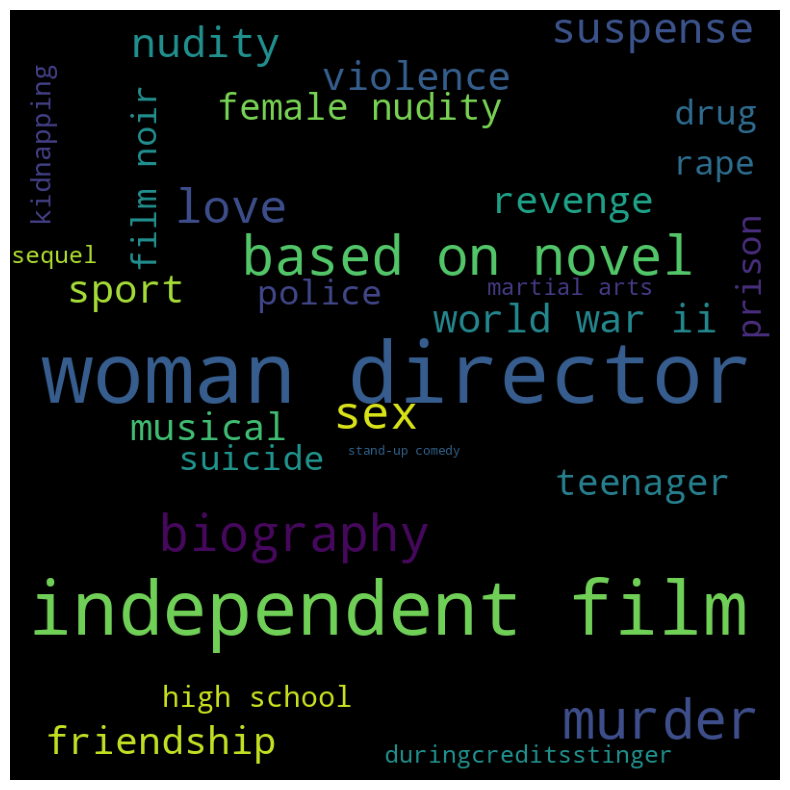

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cloud_instance = WordCloud(width = 800, height = 800)

cloud = cloud_instance.generate_from_frequencies(keywords_count_by_genre['Drama'])
array = cloud.to_array()

plt.figure(figsize = (10, 10))
plt.imshow(array)
plt.axis('off')
# plt.savefig('/content/drama_wordcloud.png')
plt.show()

# Plot

In [ ]:
import numpy as np
import pandas as pd
from plotly import express as px # --> 간단한 plot
import plotly.graph_objects as go # --> 구체적 plot

movie_meta = pd.read_csv('/content/testfile_percent.csv')
movie_genres = pd.read_csv('/content/final.csv')
movie_vote_avg = pd.read_csv('/content/vote_average.csv')

In [ ]:
# 1. 장르 분포 pie chart
labels_list = movie_meta.value_counts('genres').index
values_list = movie_meta.value_counts('genres').values

fig = go.Figure(data=[go.Pie(labels=labels_list,
                             values=values_list,
                             marker_colors = ['#EF553B', '#FFD700', '#00FA9A', '#00BFFF','#E6E6FA','#F8F8FF',
                                              '#FFF5EE','#FAEBD7', '#FFF0F5', '#FFE4E1','#DCDCDC', 'D3D3D3',
                                              '#C0C0C0','A9A9A9', '#808080', '#696969', '#778899', '708090',
                                              '#2F4F4F','#000000'])])

fig.update_layout(title_text='장르별 개봉 영화 분포')
fig.show()

In [ ]:
# 년도별 장르별 영화
    # line plot



# Data set 년도별로 정렬하기
movie_meta_yearsort = movie_meta.sort_values('year')

# 멀티인덱스 [장르, 년도] 별 영화수 count
df = movie_meta_yearsort.groupby(['genres','year']).count()

# 영화 Count없는 칸에 0 채우기
df = df.unstack(fill_value=0).stack()

# (Column별로 각각 conunt 상태이므로) 다중 Column중 하나 선택
df = df['release_date']



# x축 범위 : 년도
x_list = movie_meta_yearsort['year'].unique()

# 범례 범위 : 장르
genres_list = movie_meta_yearsort['genres'].unique()

# Y축 범위 : [[영화수 count for 년도별] for 장르별]
y_list = [[df.loc[i, j] for j in x_list] for i in genres_list]




# plot

fig = go.Figure()

for i in range(len(y_list)):
    fig.add_trace(go.Scatter(x = x_list,
                             y = y_list[i],
                             mode = 'lines',
                             name = genres_list[i]))

fig.show()

In [ ]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=2,
                    specs=[[{}, {}],
                    [{"colspan": 2}, None]],
                    subplot_titles=('장르별 개봉 영화 수 (all)', '장르별 개봉 영화 수 (최근 10년)', "'드라마' 월별 개봉 영화 수"))

# 장르별 A-Z 정렬
movie_meta_genresort = movie_meta.sort_values('genres')

colors = ['#636EFA',] * len(movie_meta_genresort['genres'].unique()) # 기본 색
colors[-7] = 'crimson' #Drama 강조 색



# 2) 장르별 개봉 영화 수 (all)
fig.add_trace(go.Scatter(
    x = movie_genres['count'],
    y = movie_genres['genres'][::-1],
    marker = dict(color=colors, size=12),
    mode = 'markers'),
    row=1,
    col=1)
fig.update_xaxes(title_text='영화 수 (개)', row=1, col=1)
fig.update_yaxes(title_text='장르', row=1, col=1)



# 2) 장르별 개봉 영화 수 (최근 10년)
fig.add_trace(go.Scatter(
    x = movie_genres['count_10'],
    y = movie_genres['genres'][::-1],
    marker = dict(color=colors, size=12),
    mode = 'markers'),
    row=1,
    col=2)
fig.update_xaxes(title_text='영화 수 (개)', row=1, col=2)
#fig.update_yaxes(title_text='장르', row=1, col=2)



# 2-1) '드라마' 월별 개봉 영화 수

Month = ["December", "November","October","September", "August", "July", "June", "May","April", "March","Feburary","January"]

fig.add_trace(go.Scatter(
    x = [312, 223, 259, 395, 205, 145, 183, 190, 174, 165, 184, 152],
    y = Month,
    marker = dict(color="crimson", size=12),
    mode = "markers"),
    row=2,
    col=1)
fig.update_xaxes(title_text='영화 수 (개)', row=2, col=1)
fig.update_yaxes(title_text='월', row=2, col=1)

fig.update_layout(title_text="개봉 영화 수",
                  showlegend=False,
                  height = 2000)

fig.show()

In [ ]:
# 3) 장르별 수익/예산 (평균)
    # bar plot


colors = ['#636EFA',] * len(movie_meta_genresort['genres'].unique()) # 기본 색
colors[6] = 'crimson' #Drama 강조 색


fig = go.Figure(data=[go.Bar(
    x = movie_meta_genresort['genres'].unique(),
    y = movie_meta_genresort.groupby(['genres']).mean()['rvn_per_bdgt'],
    marker_color=colors)])

fig.update_layout(title_text='장르별 수익/예산 (평균)')

fig.show()

<ipython-input-9-9992c8745155>:29: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
# 4. 장르별 평균 평점 (vote_avg로 변경 )
    # bar plot

colors = ['#636EFA',] * len(movie_vote_avg['genres']) # 기본 색
colors[6] = 'crimson' #Drama 강조 색

fig = go.Figure(data=[go.Bar(
    x= movie_vote_avg['genres'],
    y = movie_vote_avg['vote_average'],
    marker_color=colors)])

fig.update_layout(title_text='장르별 평균 평점')